# Word Choice in Translations of *Notes from Underground*

## Cassandra Calciano 

14 August 2022

Introduction to Computational Literary Analysis 

Department of Digital Humanities, University of California, Berkeley

Instructure: Jonathan Reeve

In [1]:
import requests
import nltk
import pandas as pd
from sklearn.decomposition import PCA
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.sentiment import SentimentIntensityAnalyzer
import spacy
from main import Text

In [2]:
nlp = spacy.load('en_core_web_lg')
nlpRus = spacy.load("ru_core_news_lg")

In [3]:
def removePunctuation(text, toRemove):
    """
    text: string of text to remove puncatuation from
    toRemove: string of characters that you want to remove from text
    returns: text as a string stripped of the strings in toRemove
    """
    for punct in toRemove:
        text = text.replace(punct, ' ')
        
    for num in ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']: #to remove page numbers
        text = text.replace(num, ' ')
    return text

### Loading and Cleaning of Corpus

In [4]:
response = requests.get("https://www.gutenberg.org/cache/epub/600/pg600.txt")
garnett = response.text
garnett = garnett[1154:245047] 
garnett = removePunctuation(garnett, ['Fyodor Dostoevsky'])

coulson = open("NotesFromUnderground_Jesse Coulson.txt", "r").read()
coulson = coulson[17065:239936] 
coulson = removePunctuation(coulson, ['Fyodor Dostoevsky'])

peaver = open("Pevear, Richard.rtf", encoding='utf-8', errors='ignore').read()
peaver = peaver[51726:241247]
remove = ['\\scaps0', '\\fs20', '\\fs24\\par', '\f0\fs24\par', '\i0', '\n', 
          '\\scaps', '\fs18', '\fs16', '\emdash', '\\fs16', '\\i', '\\', 
          'Fyodor Dostoevsky', 'nosupersub', 'super', 'fs ', 'par ']
peaver = removePunctuation(peaver, remove)

macAndrew = open("Notes_MacAndrew.txt").read()
macAndrew = macAndrew[174779:409416] 
remove = ['\scaps0', '\fs20 ', '\fs24 ', '\f0\fs24\par ', 
          '\i0', 'Fyodor Dostoevsky']
macAndrew = removePunctuation(macAndrew, remove)

hogarth = open("Hogarth NotesFromUnderground.rtf").read()
hogarth = hogarth.replace("\'97", "--")
remove = ['\\\n', '~', '\\', "\\\\", "^", 'Fyodor Dostoevsky']
hogarth = removePunctuation(hogarth, remove)

original = open("Записки из подполья.txt").read()

In [5]:
notesRaw = {'hogarth-1913': hogarth, 'garnett-1918': garnett, 'macAndrew-1961': macAndrew, 'coulson-1972': coulson, 'peaver-1994': peaver}
notes = {name: text.lower() for name, text in notesRaw.items()}

In [6]:
notesDoc = {name: nlp(text) for name, text in notes.items()}
notesDocRus = nlpRus(original)

In [7]:
def avgSentenceLen(doc, text):
    """
    doc: SpaCy doc object
    text: string version of the SpaCy doc object
    returns: average sentence length (int)
    """
    if doc[0].lang_ == 'en':
        words = doc
        sentences = nltk.sent_tokenize(text)
    else:
        words = doc
        sentences = nltk.sent_tokenize(text, language="russian")
    return len(words) / len(sentences)

In [8]:
avgSentLen = {name: avgSentenceLen(notesDoc[name], text) for name, text in notes.items()}
avgSentLen['original-1864'] = avgSentenceLen(notesDocRus, original)

In [9]:
avgSentLen

{'hogarth-1913': 26.385623510722795,
 'garnett-1918': 25.629076086956523,
 'macAndrew-1961': 20.430379746835442,
 'coulson-1972': 24.142159257449926,
 'peaver-1994': 21.870777479892762,
 'original-1864': 19.635328836424957}

When meeting the Underground Man for the first time one is struck with confusion, distrust, and a heavy, leadened stone at the bottom of one’ stomach. The first time that we meet the Underground Man is as the narrator in Fyodor Dostoevsky’s novella, *Записки из подполья*, most often translated, as *Notes from Underground*. Written in two parts, with the first antedating the second, the Underground Man introduces his illness of inertia due to his fervent consciousness. Here he criticizes every philosophical belief present in the 19th century, including determinism, utilitarianism, in favor of existentialism. In the second part, the Underground Man recounts the trials and tribulations in his early twenties that led to his philosophical belief and retreat to live underground. We are reintroduced to the Underground Man, in English, by J.C. Hogarth in 1913 under the title *Letters from the Underword*, Constance Garnett in 1918, Andrew R. MacAndrew in 1961, Jessie Coulson in 1972, and Richard Pevear and Larissa Volokhonsy in 1994. With the average sentence length of the original text, at 19.6, and the translations having an average sentence length in the range of 20.4 to 26.4, this study aims to look at the nuances in word choice and comment on how the word choices of the respective author differentiate the narrator’s character across translations.


When looking at the translations, I first used PCA with a maximum of 200 features to see which translations are most closely related. When applying PCA a grouping of translations appears. The most closely related texts are Coulson, Garnett, and Peaver and Volokhonsy (denoted just as ‘peaver’ in the code for ease of use). While the Hogarth translation differs most in Component 1, MacAndrew differs most in Component 2 compared to the cluster. The Hogarth translation has the highest type-token-ratio and the highest average sentence length, indicating that his translation has the richest and most varied vocabulary. Likewise, Hogarth has the highest proportion of Latinate words, as seen when using macro-etymology, leading to a more formal, socially elite sounding text. Uniquely, MacAndrew’s translation is the only translation with a non-zero proportion of words of baltic-slavic origin. Hogarth, Garnett, and Coulson are British, MacAndrews and Peaver are American, and Volokhonsy, Russian. As seen in the graph, there does not appear to be any correlation in the nationalities of the author. 

In [10]:
allTexts = []
for name, text in notes.items():
    allTexts.append(text)
    
allLabels = []
for name, text in notes.items():
    allLabels.append(name)

In [11]:
tfidfVectorizer = TfidfVectorizer(min_df=1, max_features=200)
textMatrix = tfidfVectorizer.fit_transform(allTexts)
denseTextMatrix = textMatrix.todense()

In [12]:
pca = PCA(n_components=2)
textPoints = pca.fit_transform(denseTextMatrix)
textDf = pd.DataFrame(textPoints, index=allLabels, columns=['Component 1', 'Component 2'])

/Users/cassandracalciano/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


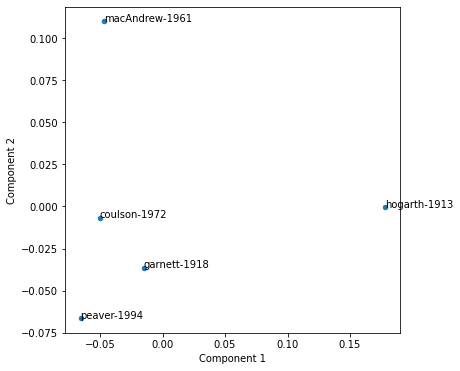

In [13]:
ax = textDf.plot(kind='scatter', x='Component 1', y='Component 2', figsize=(6, 6))
for title, points in textDf.iterrows():
    ax.annotate(title, points)

In [14]:
notesText = {name: Text(text) for name, text in notes.items()}
for name, text in notesText.items(): 
    print(name)
    print(text.familyStats())
    print()

hogarth-1913
{'Latinate': 64.64776632302404, 'Germanic': 33.90737269603248, 'Hellenic': 0.937207122774133, 'Uralic': 0.0937207122774133, 'Semitic': 0.06248047485160886, 'Indo-Iranian': 0.10934083099031551, 'Austronesian': 0.03124023742580443, 'Celtic': 0.023430178069353325, 'Other': 0.14058106841611995, 'Turkic': 0.04686035613870665, 'Balto-Slavic': 0.0, 'Japonic': 0.0}

garnett-1918
{'Latinate': 62.71855611957136, 'Germanic': 36.285015980447454, 'Uralic': 0.1128031584884377, 'Hellenic': 0.39481105470953193, 'Other': 0.1128031584884377, 'Semitic': 0.14100394811054712, 'Indo-Iranian': 0.10340289528106787, 'Austronesian': 0.037601052829479224, 'Japonic': 0.037601052829479224, 'Turkic': 0.05640157924421885, 'Celtic': 0.0, 'Balto-Slavic': 0.0}

macAndrew-1961
{'Latinate': 60.830999066293174, 'Germanic': 37.77777777777777, 'Uralic': 0.11204481792717086, 'Hellenic': 0.5788982259570497, 'Other': 0.19607843137254904, 'Semitic': 0.20541549953314658, 'Indo-Iranian': 0.10270774976657328, 'Austron

By first analyzing Dostevsky’s original text we can highlight the choices each translator had to make in the process of translating. The original text opens as follows, 

> Я человек больной… Я злой человек. Непривлекательный я человек.

Dostoevsky uses the word человек (pron. chelovyek), which translates to man, person, or human. Although the above is grammatically correct the above translated literally is, “I person sick… I evil person. Unattractive I person. All translators chose the word man, because the narrator is a man indeed. The last word in a sentence is the emphasized word in Russian. Therefore, it is the fact that the Underground Man is a person, a human, a man, that Dostoevsky wants the reader to know. When put at the end at the end of the sentence, the narrator uses “person” to gain sympathy from their reader. This nuance cannot fully be translated into English. Noticeably, Dostoevsky chose человек, instead of мужчина (pron. moozhchina), which explicitly translates to man without any alternative. This demonstrates the lack of importance masculinity is to the narrator’s character. Also, it is important to note that the word man or person is not needed to create the verb “am.” The phrase “I tall” would create the sentence: I am tall, in Russian. With this in mind Dostoevsky chooses to include a superfluous noun, second he chooses one that is neuter in connotation and can be read ambiguously. This matches the superfluous vocabulary throughout the text and the ambiguity of what the Underground Man says. 

The translations of the opening sentence is shown below in order of publication year: 

> I AM ill ; I am full of spleen and repellent. (Hogarth, 1)

> I am a sick man.... I am a spiteful man. I am an unattractive man. (Garnett, 1)

> I'm a sick man... a mean man. There's nothing attractive about me. (MacAndrews, 1)

> I AM a sick man…. I am an angry man. I am an unattractive man. (Coulson, 1)

> I am a sick man... I am a wicked man. (Pevear and Volokhonsky, 1)

Within the translations it is imperative to the forming of the narrator’s character to contradict the word, “man,” with adjectives like sick, wicked, and unattractive. This creates a similar sense of sympathy and a tone of neuter weakness that is present in the original version. In the Western tradition, a man and even more so a protagonist, is physically strong, masculine, and morally just in character. While the narrator is strongly opinionated, once remarking that the normal man is “stupid,” in comparison of himself (Garnett, part 1, ch. III). He is feeble, timid in his ability to interact with other people and society. His feebleness is demonstrated with his indecision and his contradictions. The Underground Man is full of contradictions that he exposes in the first chapter; he is ill, but does not know from what. He won't see the doctor, but trusts the medical field. He is educated, but superstitious. This sets up the narrator to be seen as unreliable and at worst deceiving for the sake of it. 

Unique to Hogarth and Coulson is the capitalization of "AM." This bold start to the text forcefully interrupts the reader by daring the reader not to trust the Underground Man. From the beginning, this starts an expectation that the Underground Man will be in your face throughout these editions. While spleen is an organ, and the narrator goes on to say his liver is diseased in all five translations, spleen is also a verb for resentful anger. To be full of resentful anger and repellent shows that the main antagonist is the narrator’s own mind. These are characteristics of an anti-hero (Matlaw, 108). Coulson and MacAndrew choose a more comfortable vernacular to the English ear of, "angry" and "mean." While one can be angry and mean in the moment, these words do not encapsulate the overarching personality of the Underground Man or the internal struggle he has with himself. Looking at the graph of word count graphs below, Hogarth uses ‘spleen more than any other author. Whereas Garnett uses spite. Where spite differs from mean, angry, spleen, and wicked, is a tinge of jealousy. Garnett markedly describes the Underground Man as jealous of those who are not too conscious, like him, but can live a normal, stupid life. Peaver and Volokhonsy also uniquely use the word wicked. Peaver comments on the word wicked saying, 

> “It speaks for that habit of substituting the psychological for the moral, of interpreting a spiritual condition as a kind of behavior, which has so bedeviled our century” (foreword).

This connotation is evil, devilish, and morally corrupt, which they then go on to use the most throughout the text. Also included in the graph is the word “love.” While not introduced in the beginning of the text, one of the Underground Man’s main dilemmas is his inability to love another person. And, showing the occurrence of love next to such negative words shows a contrast that illuminates how the Underground Man spends most of the time, mainly in the second part, trying and failing to integrate into society. This contrast also shows the emotionally charged state of each translation, with Hogarth’s having the largest occurrence of love. 


In [15]:
wordCounts = {}
words = ['spleen', 'spite', 'angry', 'mean', 'love', 'ill', 'sick', 'wick', 'unattractive']
for name in notesDoc.keys():
    countDict = {}
    for stem in words: 
        countDict[stem] = len(Counter([token for token in notesDoc[name] if token.text.startswith(stem)]))
    wordCounts[name] = countDict

<AxesSubplot:>

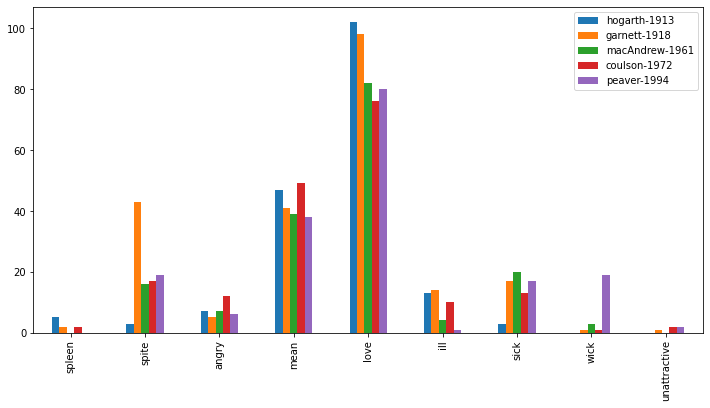

In [16]:
pd.DataFrame(wordCounts).plot(kind='bar', figsize=(12,6))

When upset at his fellow classmate, Zverkov, for insulting him and ignoring him at dinner, the Underground Man goes to avenge himself. The rant that is meant to get revenge, but does not actually occur in front of Zverkov, but in private, must be read like the structure of the overall novella. That is, the narrator opines his philosophy before the events happen. The Underground Man desperately states, 

> " Look, villain, upon my hollow cheeks and ragged clothes! Everything have I now lost--my career, my happiness, my art, my learning, the woman whom I love, and all because of you! Here are pistols. I had come hither to fight a duel with you, but--but now I pardon you." (Hogarth, Part 2, Ch. V)

> I shall say to him: “Look, monster, at my hollow cheeks and my rags! I’ve lost everything—my career, my happiness, art, science, the woman I loved, and all through you. Here are pistols. I have come to discharge my pistol and ... and I ... forgive you. (Garnett, Part 2, Ch. V)

> I'll tell him : 'Look, you monster-look at these sunken cheeks and tattered clothes! I've lost everything--career, happiness, art, science, the woman I loved-and all through your fault. Here are the pistols. I've come to unload my pistol and . . . and I forgive you.' (MacAndrew, Part 2, ch. V)

> I shall say, “Look, monster, look at my wasted cheeks, and at my rags and tatters! I have lost everything – career, happiness, art, science, a loved woman, and all because of you. Look at these pistols. I have come to discharge my pistol, and… and I forgive you.” (Coulson, Part 2, Ch. V)

> I'll say: 'Look, monster, look at my sunken cheeks and my rags! I lost everything -career, happiness, art, science, a beloved woman and all because of you. Here are the pistols. I've come to discharge my pistol, and... and I forgive you.' (Peaver and Volokhonsky, Part 2, Ch. V)

By reading this moment like the structure of the overall text we see that the woman he loves is Liza, the prostitute he meets after dinner with his former classmates. Hogarth’s edition of the impassioned rant shows much more emotion because of the multiple exclamation marks and the use of the word villain. Villain has a fantastical connotation that makes the Underground Man look hysterical. It is also only Hogarth that uses the repetition of “but,” rather than the repetition of “and.” The repetition of “but,” makes it sound like the Underground Man changed his mind in the moment, whereas the “and” says that he had planned all along to fire his pistol. Hogarth’s translation sneaks in another contradiction in the thought process of the Underground Man to go beyond his already stated contradictions. 

The duel, the discharging of pistols, the fight never happens because the Underground Man concedes that this fantasy is taken straight out of the life of “Silvio,” the main character in the Pushkin's poem, “The Shot” The original text does not include the name Pushkin, just the name Silvio. This is largely because this was an allusion everyone in his time period would understand without additional information. However, this allusion would not be readily in the English readers mind as late as 1913. Hogarth, Coulson, and Peaver and Volokhonsy leave Pushkin out, although they still include the name Silvio. However, MacAndrew and Garnett include the name Pushkin, making it easier for the reader to draw a comparison between the Underground Man and Silvio. Both subjects are disgruntled former bureaucrats with a want for revenge against their enemies. Silvio, like Pushkin in real life, dies from a duel fighting for the love of their lives. MacAndrew and Garnett expect more of the reader and are tactful as to how to get their comparisons across. They use less emotionally charged language, compared to that of Hogarth, in particular. MacAndrew and Garnett also gain credibility for including Pushkin, as referencing a hallmark Russian poet in your writing makes it sound intellectually elite, as is consistent with the Underground Man’s personality. 

Hogarth uses the words, “hither” and “duel” giving way to a medieval connotation. Whereas the other translations use the word “discharge” instead of duel. The discharging of a pistol does not imply a fight against two people, but a duel does. However, we see that no one else is actually in this scene so discharge might be more appropriate since the Underground Man is alone. However, a duel shows the honor and internal conviction the Underground Man has to fight for the women he loves, and other things in his life like learning, as Hogarth remarks. Love and learning show that Hogarth’s translation demonstrates that the Underground Man is fighting for his life. 


In [17]:
sentimentAnalyzer = SentimentIntensityAnalyzer()

In [18]:
def getSentiment(text):
    return sentimentAnalyzer.polarity_scores(text)['compound']

In [19]:
allSentiments = {}
for name, text in notes.items():
    sentences = nltk.sent_tokenize(text)
    allSentiments[name] = pd.Series([getSentiment(sent) for sent in sentences])
    
allSentimentsDf = pd.DataFrame(allSentiments)

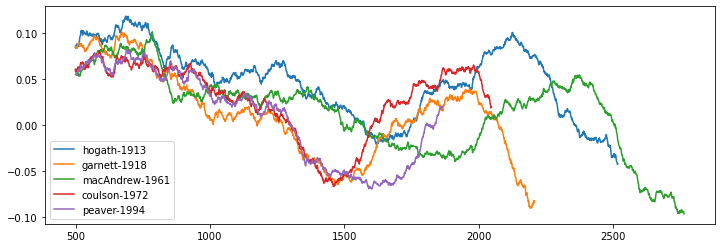

In [20]:
for name, sentiments in allSentiments.items(): #sentiments is a series
    ax = sentiments.rolling(500).mean().plot(figsize=(12, 4))
    ax
ax.legend(['hogath-1913', 'garnett-1918', 'macAndrew-1961', 'coulson-1972', 'peaver-1994'])

Late in the text, there is a poem that is is separated from the rest of the text before Liza, a  comes to his house: 

> ln my house, with daring step and free, / Enter thou and reign." (Hogarth, Part 2, ch. 9)

> Into my house come bold and free, / Its rightful mistress there to be. (Garnett, Part 2, ch. 9)

> And now, full mistress of the place, Come bold and free into my house. (MacAndrew, Part 2, ch. 9)

> Enter now, then, bold and free; / Be mistress of my house and me. (Coulson, Part 2, ch. 9)

> Enter now then, bold and free, / Be mistress of my house and me.(Peaver and Volokhonsy, Part 2, ch. 9)

It's not clear whether this is a poem that is written and made up by the Underground Man or a poem by Dostoevsky that is meant to represent the author’s interaction with the reader and his subject. Though, this poem does appear in the original. 

To understand where Liza fits into the character development of the Underground Man, I used sentiment analysis across all translations. The dip around 1500 sentences for Peaver, Coulson, around 1700 for Hogarth, and around 2400 sentences, represents the initial meeting of the Underground Man and the prostitute Liza. After acquiring her services, the Underground Man offers to save her, from what is not explicit. But, the notion of needing to save the prostitute shows that the Underground Man’s morals do not truely allow for the freedom to destory oneself as he previously was in support of in Part 1. While all translations follow the same general curve unsurprisingly, the Hogarth translation is consistently higher than all others. It is not the case that Hogarth’s Underground Man is happier, more functional, or positive, but that Hogarth uses less explicitly negative language. We also see the plot that there is no happy ending in the Underground Man’s life. The happy part in the graph above occurs at the beginning, with a peak in the middle. This anti-plot, with a happy beginning and rapidly falling action is consistent with the anti-hero that the Underground Man is. The use of the word rightful by Garnett implies that the mistress, meaning Liza, belongs and has always belonged in the house and to the Underground Man. Hogarth uses the word “reign” to describe the position Liza should hold in the Underground Man’s house. This gives a regal, official feel that is not replicated elsewhere. All other translation use the word “mistress”; mistress is sexual in nature and without an implied love for one another. There's little respect for a mistress, but someone who reigns holds a high respectable position. When he attempts to save Liza, this is the Underground Man’s only interaction with someone of the opposite sex. This shows that there is an attempt to integrate into society as a cliche, masculine protagonist. However, he ultimately fails as seen by the steep trend downward in the sentiment graph. 

While translations are not measured in accuracy, all translations exist on a scale that places them between the original text and making the translation a distinct story of its own. When looking at the five translations here, of the thirteen that exist, we see that Hogarth has jarring word choices that present a more emotional, erratic Underground Man, compared to the rest even when taking into account the language more prevalent in early 1900’s Britain. This is not to say that the Hogarth translation is more or less reflective of Dostoevsky, but that Hogarth’s Underground Man gives us a unique anti-hero to analysis among the rout of Underground Men. 

# Works Cited

Dostoevsky, Fyodor. *Letters from the Underworld*. Translated by Hogarth, C. J. London, J.M. Dent and Sons, ltd.; New York, E.P. Dutton & Co, 1913

Dostoevsky, Fyodor. *Notes from the Underground*. Translated by Garnett, Constance. New York: Dover Publications, 1918

Dostoevsky, Fyodor. *Notes from Underground*. Translated by MacAndrews, Andrew R. The New American Library, New York AND Toronto, 1961

Dostoevsky, Fyodor. *Notes from Underground*. Translated by Coulson, Jessie. Penguin Putnam Inc., 1972

Dostoevsky, Fyodor. *Notes from Underground*. Translated by Pevear, Richard and Volkhonsky, Larissa. Penguin Random House, 1994

Matlaw, Ralph E. "Structure and Integration in *Notes from Underground*." Modern Language Association of America, vol. 73, no. 1, march 1958, pp. 101-109. JSTOR, www.jstor.org/stable/460279